# Phylogenetic tree of the Sars-Cov-2 sequencing data

## Downloading the data

We downloaded the raw sequencing data and the associated metadata of 733 isolates (all the ones available on Mar 17) from the GISAID web site. This data set includes:
- 98 isolates from the US 
- 635 isolates from other countries/sources


## Generating a sequence alignment

We use [MAFFT](https://mafft.cbrc.jp/alignment/software/) to align all sequences. 

**NOTE** The code is commented because it takes 2-3 hours to align the sequences with a laptop. We provide the `.fasta` file with the aligned sequences.

In [11]:
#system("mafft --auto data/gisaid_cov2020_sequences_filtered.fasta > data/gisaid_cov2020_sequences_filtered_ali.fasta")

## Phylogenetic tree reconstruction
We load the alignment (converting it to `DNAbin` format, which is suitable to perform fast caculations. The `adegenet` provides a function to do this) and calculate a distance matrix (using the `ape` package):

In [12]:
# we load the alignment we just saved
library(adegenet)
library(ape)
ali_reloaded = fasta2DNAbin(file="data/gisaid_cov2020_sequences_filtered_ali.fasta")

# we calculate the distance between the sequences
d_mat = dist.dna(ali_reloaded)


 Converting FASTA alignment into a DNAbin object... 


 Finding the size of a single genome... 


 genome size is: 35,024 nucleotides 

( 585  lines per genome )

 Importing sequences... 
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

We generate a tree using the [BIONJ](http://www.atgc-montpellier.fr/bionj/) algorithm:

In [40]:
tree = bionj(d_mat)

Now we load the table of the annotations and we check how it looks like:

In [21]:
tab = read.csv("data/metadata_cov2020.tsv",sep="\t",stringsAsFactors=FALSE)
head(tab,2)

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,division_exposure,location,⋯,length,host,age,sex,originating_lab,submitting_lab,authors,url,title,date_submitted
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Anhui/SZ005/2020,ncov,EPI_ISL_413485,?,2020-01-24,Asia,China,Anhui,Anhui,Suzhou,⋯,29860,Human,58,Male,"Department of microbiology laboratory,Anhui Provincial Center for Disease Control and Prevention","Department of microbiology laboratory,Anhui Provincial Center for Disease Control and Prevention",Li et al,https://www.gisaid.org,?,2020-03-05
2,Australia/NSW01/2020,ncov,EPI_ISL_407893,?,2020-01-24,Oceania,Australia,New South Wales,Hubei,Sydney,⋯,29782,Human,43,Male,Centre for Infectious Diseases and Microbiology Laboratory Services,NSW Health Pathology - Institute of Clinical Pathology and Medical Research; Westmead Hospital; University of Sydney,Eden et al,https://www.gisaid.org,?,2020-02-06


The tags of the strains in our tree are different:

In [41]:
tree$tip[1:10]

[1] "hCoV-19/Wuhan/WIV06/2019|EPI_ISL_402129|2019-12-30"        
 [2] "hCoV-19/Wuhan/WIV07/2019|EPI_ISL_402130|2019-12-30"        
 [3] "hCoV-19/Guangdong/20SF012/2020|EPI_ISL_403932|2020-01-14"  
 [4] "hCoV-19/Guangdong/20SF013/2020|EPI_ISL_403933|2020-01-15"  
 [5] "hCoV-19/Guangdong/20SF014/2020|EPI_ISL_403934|2020-01-15"  
 [6] "hCoV-19/Guangdong/20SF025/2020|EPI_ISL_403935|2020-01-15"  
 [7] "hCoV-19/Guangdong/20SF028/2020|EPI_ISL_403936|2020-01-17"  
 [8] "hCoV-19/Guangdong/20SF040/2020|EPI_ISL_403937|2020-01-18"  
 [9] "hCoV-19/Wuhan/IPBCAMS-WH-03/2019|EPI_ISL_403930|2019-12-30"
[10] "hCoV-19/Wuhan/HBCDC-HB-01/2019|EPI_ISL_402132|2019-12-30"

It is very useful to have the same IDs in the tree and the metadata, so we use `gsub` to reformat the tags in the tree:

In [43]:
library(magrittr)
tree$tip.label = tree$tip %>% 
gsub(pattern = "hCoV-19/", replacement = "") %>% 
gsub(pattern = "\\|[A-Z0-9_\\-]+", replacement = "",perl = TRUE)
tree$tip=tree$tip.label

The first complete genome is the one of the isolate "Wuhan-Hu-1" ([NCBI](https://www.ncbi.nlm.nih.gov/nuccore/MN908947))! We search for the ID of this isolate and we root the tree:

In [48]:
tab[grep("Wuhan-Hu-1",tab$strain),]
rtree=root(tree,outgroup="Wuhan-Hu-1/2019")

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,division_exposure,location,⋯,length,host,age,sex,originating_lab,submitting_lab,authors,url,title,date_submitted
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
746,Wuhan-Hu-1/2019,ncov,EPI_ISL_402125,MN908947,2019-12-26,Asia,China,Hubei,Hubei,Wuhan,⋯,29903,Human,?,?,unknown,National Institute for Communicable Disease Control and Prevention (ICDC) Chinese Center for Disease Control and Prevention (China CDC),Zhang et al,https://www.gisaid.org,?,2020-01-12


We create different categories for the isolates ("USA", "other_countries") and we display the tree using the `ggtree` package:

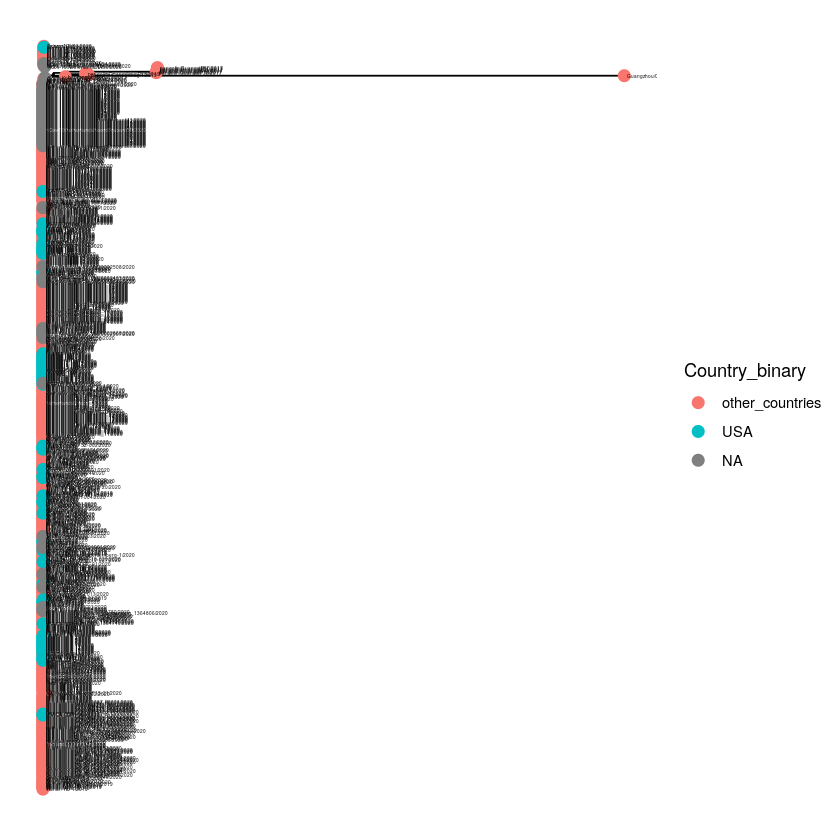

In [73]:
tab$Country_binary = ifelse(tab$country == "USA","USA","other_countries")
md_sel=tab[,c("strain","Country_binary")]

# displaying tree
library(ggtree)
g=ggtree(rtree) 
g %<+% md_sel + geom_tippoint(aes(color=Country_binary), size=3) + geom_tiplab(size=1)
g_final = g %<+% md_sel + geom_tippoint(aes(color=Country_binary), size=3) + geom_tiplab(size=2)
ggsave("out/tree_all_isolates.pdf",g_final, height = 70 , width = 30, limitsize=FALSE)

Although the image in the notebook will be a bit difficult to read, the `.pdf` you can download/open the `.pdf` image we generated (`out/tree_all_isolates.pdf`) with your favorite pdf viewer.

Some of the isolates sampled in non-human hosts are so distant from the human strains that we cannot appreciate the differences between them. Let's work with a smaller dataset of 141 human strains (including 78 US isolates / all the ones available on GISAID on Mar 12). 


 Converting FASTA alignment into a DNAbin object... 


 Finding the size of a single genome... 


 genome size is: 29,980 nucleotides 

( 501  lines per genome )

 Importing sequences... 
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

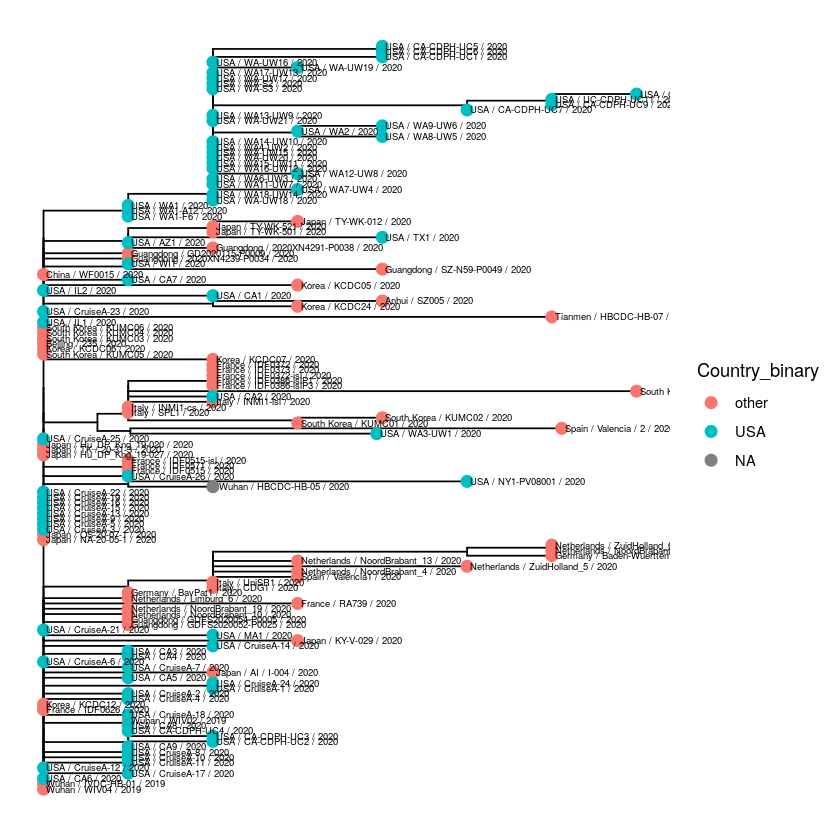

In [82]:
# we load the sequence alignments
ali = fasta2DNAbin(file="data/sars_cov2_ali.fasta")

# we calculate the distance between the sequences
d_mat = dist.dna(ali_subset_human_strains)

# we calculate the tree and root it
tree = bionj(d_mat)
rtree=root(tree, outgroup="hCoV-19/Wuhan/WIV04/2019|EPI_ISL_402124")

# we reformat the IDs to match the ones in the metadata table
library(magrittr)
rtree$tip.label = rtree$tip %>% 
gsub(pattern = "hCoV-19/", replacement = "") %>% 
gsub(pattern = "\\|[A-Z0-9_\\-]+", replacement = "",perl = TRUE) %>%
gsub(pattern = "\\/", replacement = " \\/ ",perl = TRUE)

# we load the metadata and create a new column: "USA" / "other_countries" 
md = read.csv("data/metadata/geo_loc.tsv",sep="\t")
md$Country_binary = ifelse(md$Country == "USA","USA","other")
md_sel=md[,c("Isolate_short_name","Country_binary")]

# displaying tree
library(ggtree)
g=ggtree(rtree) 
g %<+% md_sel + geom_tippoint(aes(color=Country_binary), size=3) + geom_tiplab(size=2)
g_final = g %<+% md_sel + geom_tippoint(aes(color=Country_binary), size=3) + geom_tiplab(size=3)
ggsave("out/tree_us_vs_other_isolates.pdf",g_final, height = 20 , width = 30)

## Questions
- Can you list one or more examples of community spread?